In [1]:
#Загрузим библиотеки и посмотрим на данные
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline
df = pd.read_csv("./aug_train.csv")
df.head(10)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
5,21651,city_176,0.764,NaN,Has relevent experience,Part time course,Graduate,STEM,11,NaN,NaN,1,24,1.0
6,28806,city_160,0.920,Male,Has relevent experience,no_enrollment,High School,NaN,5,50-99,Funded Startup,1,24,0.0
7,402,city_46,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18,1.0
8,27107,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,50-99,Pvt Ltd,1,46,1.0
9,699,city_103,0.920,NaN,Has relevent experience,no_enrollment,Graduate,STEM,17,10000+,Pvt Ltd,>4,123,0.0


enrollee_id: уникальный идентификатор кандидата

city: Код города

city_development_index: индекс развития города (в масштабе)

gender: Пол кандидата

relvent_experience: Соответствующий опыт кандидата

enrolled_university: Тип зачисленных университетских курсов, если таковые имеются

education_level: Уровень образования кандидата

major_discipline: Обучение основной дисциплине кандидата

experience: Кандидатский общий стаж в годах

company_size: Количество сотрудников в компании текущего работодателя

company_type: Тип текущего работодателя

last_new_job: разница в годах между предыдущей работой и текущей работой

training_hours: завершенные часы обучения

target: 0 - Не ищу смены работы, 1 - Ищу смены работы

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [3]:
df['target'].value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

In [4]:
df.shape

(19158, 14)

In [5]:
df.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [6]:
#заполним пробелы
for column in ['gender','enrolled_university','education_level','major_discipline', 'experience', 'company_size', 'company_type','last_new_job']:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [7]:
df.isna().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [8]:
#удалим ненужные фичи
df = df.drop(columns=["enrollee_id"])


In [9]:
df['gender'].value_counts()

Male      17729
Female     1238
Other       191
Name: gender, dtype: int64

In [10]:
df = df.replace({'gender':{'Male':1, 'Female':0, 'Other': 0}})
df = df.astype({'gender': np.int64})

df['gender'].value_counts()

1    17729
0     1429
Name: gender, dtype: int64

In [11]:
df['enrolled_university'].value_counts()

no_enrollment       14203
Full time course     3757
Part time course     1198
Name: enrolled_university, dtype: int64

In [12]:
df = df.replace({'enrolled_university':{'no_enrollment':1, 'Full time course':0, 'Part time course': 2}})
df = df.astype({'enrolled_university': np.int64})

df['enrolled_university'].value_counts()

1    14203
0     3757
2     1198
Name: enrolled_university, dtype: int64

In [13]:
df['education_level'].value_counts() 

Graduate          12058
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64

In [14]:
df = df.replace({'education_level':{'Graduate':0, 'Masters':1, 'High School': 2, 'Phd': 3, 'Primary School': 4}})
df = df.astype({'education_level': np.int64})

df['education_level'].value_counts()

0    12058
1     4361
2     2017
3      414
4      308
Name: education_level, dtype: int64

In [15]:
df['company_size'].value_counts()

50-99        9021
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64

In [16]:
df = df.replace({'company_size':{'50-99':0, '100-500':1, '10000+':2, '10/49':3, '1000-4999':4, '<10':5, '500-999':6, '5000-9999':7}})
df = df.astype({'company_size': np.int64})

df['company_size'].value_counts()

0    9021
1    2571
2    2019
3    1471
4    1328
5    1308
6     877
7     563
Name: company_size, dtype: int64

In [17]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['target'], test_size=0.3, random_state=0)

In [18]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [19]:
df.dtypes

city                       object
city_development_index    float64
gender                      int64
relevent_experience        object
enrolled_university         int64
education_level             int64
major_discipline           object
experience                 object
company_size                int64
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [21]:
#Список признаков
categorical_columns = ['city', 'relevent_experience', 'major_discipline', 'experience', 'company_type', 'last_new_job']
continuous_columns = ['city_development_index', 'gender', 'enrolled_university', 'education_level', 'company_size', 'training_hours']

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [23]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

In [26]:
#Обучение модели
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

In [27]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [33]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score

In [31]:
regressor = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBRegressor()),
])

#обучим наш пайплайн
regressor.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('city',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='city')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='city'))])),
                                                ('relevent_experience',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='relevent_experience')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='relevent_experience'))])),
                                                ('major_discipline',
                                                 Pipeli

In [34]:
predictions =  regressor.predict(X_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(0.29508230454710316, 0.15855801200654684)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df[continuous_columns], df['target'], random_state=0)

In [43]:
import shap

In [44]:
model = xgb.train({"learning_rate": 0.01}, 
                      xgb.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

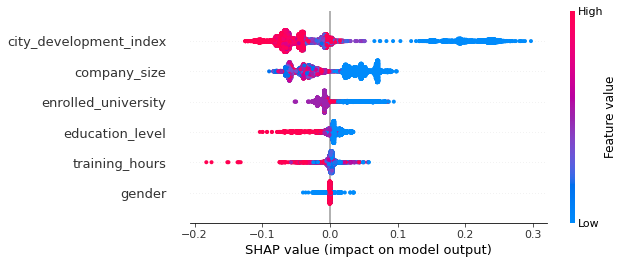

In [45]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

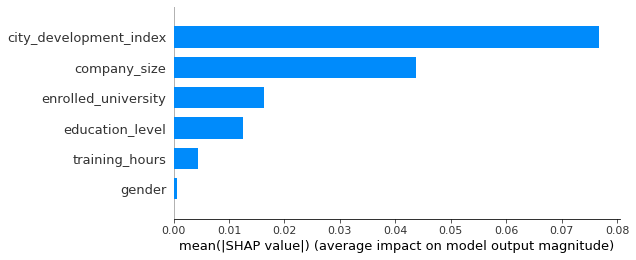

In [46]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

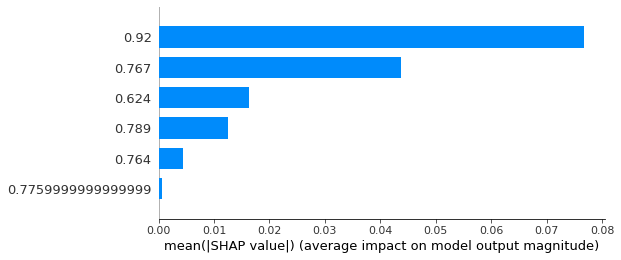

In [49]:
shap.summary_plot(shap_values, X_train['city_development_index'], plot_type="bar")

In [56]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [57]:
shap.force_plot(explainer.expected_value, shap_values[:100,:], X_train.iloc[:100,:])